## Data Challenge #1

**Author:** Leonardo Espin

**Date:** February 18, 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('employee_retention_data.csv')
print(data.shape)
data.head()

(24702, 7)


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
data.dtypes

employee_id    float64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object

In [4]:
#not an imbalanced dataset
data['quit_date'].isna().sum()

11192

In [5]:
#check nans, no rows need to be eliminated
data.isna().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

In [6]:
#convert the dates to the appropriate types 
data['join_date']=data['join_date'].astype('M')
data['quit_date']=data['quit_date'].astype('M')
data.dtypes

employee_id           float64
company_id              int64
dept                   object
seniority               int64
salary                float64
join_date      datetime64[ns]
quit_date      datetime64[ns]
dtype: object

In [7]:
#check that nans were maintained
data['quit_date'].isna().sum()

11192

In [8]:
#add a quit column 
data['quit']=data['quit_date'].notna()

In [9]:
#calculate months at company
def monthsAtCompany(start,end):
    if type(end) == type(pd.NaT):#very tricky comparison to make
        period=(pd.to_datetime('2015-12-13', format='%Y-%m-%d')
                -start)/np.timedelta64(1, 'M')
    else:
        period=(end-start)/np.timedelta64(1, 'M')
    return period

#np.vectorize(monthsAtCompany)(data['join_date'], data['quit_date'])

In [10]:
#check that calculation works
monthsAtCompany(data['join_date'][2], data['quit_date'][2])

13.996180619725251

In [11]:
#define tenure duration column
for i in range(len(data)):
    data.loc[i,'tenure']=monthsAtCompany(data['join_date'][i], data['quit_date'][i])

In [12]:
#check if tenure seems correct
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit,tenure
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,True,19.220107
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,True,11.170661
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,False,13.996181
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,True,12.780550
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,True,34.169079


count    24702.000000
mean        18.869187
std         11.880076
min          0.098565
25%         10.940676
50%         13.930471
75%         25.659664
max         58.383129
Name: tenure, dtype: float64


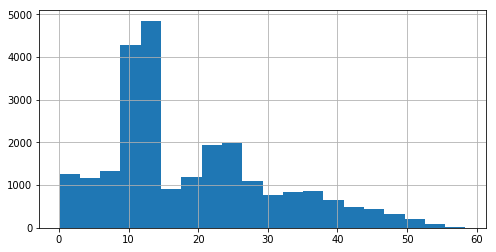

In [13]:
print(data['tenure'].describe())
data['tenure'].hist(bins=20,figsize=(8, 4))

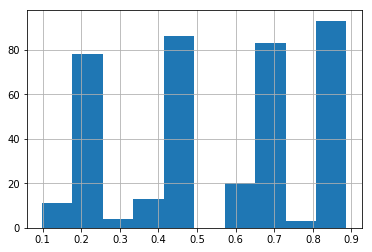

In [14]:
#people in the region below a month at the company
data[data['tenure']<1]['tenure'].hist()

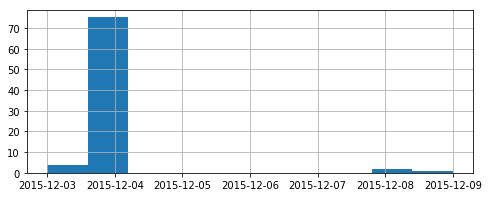

In [15]:
#people in the region near december 2015
data[data['quit_date']>pd.to_datetime('2015-12-01', format='%Y-%m-%d')
    ]['quit_date'].hist(figsize=(8, 3))

* what's tricky about this problem is that we're being asked to predict when an employer is going to quit. 
* This seems like a regression problem, but in fact mixes two predictions, whether an employee is going to quit (classification problem) and when (regression)
* might be simpler to **first attempt a binary classification** on retention and then try to predict the tenure length
* afterwards a regressor can be trained, but only by using data on employees that quit. I'm not sure how to then combine both predictions. 
* **Note:** the relevant dates (join, quit) are in the period between 2011 and 2015 which I think does not overlap with any major economical downturn which could be very important for the analysis (indeed, I confirmed this suspicion below). Also, from the description of the problem **I assume that employees that left, did so by quitting and from being fired**. 

In [16]:
#sanity checks:
print(data['seniority'].describe())
data['seniority'].value_counts().sort_index(ascending=False)

count    24702.000000
mean        14.127803
std          8.089520
min          1.000000
25%          7.000000
50%         14.000000
75%         21.000000
max         99.000000
Name: seniority, dtype: float64


99       1
98       1
29     626
28     585
27     642
26     694
25     715
24     743
23     785
22     764
21     782
20     844
19     910
18     872
17     893
16     936
15     911
14     920
13     894
12     988
11     924
10     927
9      944
8     1008
7      928
6      950
5      936
4      895
3      881
2      942
1      861
Name: seniority, dtype: int64

In [17]:
#two values are incorrect, so erase them:
data[data['seniority']> 30]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit,tenure
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,True,36.896035
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06,True,28.386620


In [18]:
data.drop([24700,24701],inplace=True)
data.shape

(24700, 9)

In [19]:
def convert4prediction(series,inverse=False):
    '''
    converts a datetime64 pandas data type to a numerical value, by 
    using unix time (number of nanoseconds since 1970-01-01) as a 
    reference point:
    https://stackoverflow.com/questions/50979873/linear-fit-to-pandas-datetime64-values
    The function returns the number of years passed since 2011-01-01
    (date from problem statement). 
    Function can apply the inverse function too by seeting the second
    parameter to True.
    '''
    if inverse:
        return pd.to_datetime((series+41)*(1e9 *60*60*24*365))
    else:
        return pd.to_numeric(series)/(1e9 *60*60*24*365) -41

In [20]:
#remove employee_id from variables
variables=data.columns.tolist()
print(variables)
del variables[0]
variables

['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date', 'quit_date', 'quit', 'tenure']


['company_id',
 'dept',
 'seniority',
 'salary',
 'join_date',
 'quit_date',
 'quit',
 'tenure']

In [21]:
#copy data to new dataframe and convert timestamp colums to numerical
df=data[variables].copy()
df['join_date']=convert4prediction(data['join_date'])
#nan positions preserved because of matching index:
df['quit_date']=convert4prediction(data[data['quit']]['quit_date'])
df.head()

,company_id,dept,seniority,salary,join_date,quit_date,quit,tenure
0,7,customer_service,28,89000.0,3.254795,4.857534,True,19.220107
1,7,marketing,20,183000.0,2.353425,3.284932,True,11.170661
2,4,marketing,14,101000.0,3.810959,NaN,False,13.996181
3,7,customer_service,20,115000.0,1.394521,2.460274,True,12.780550
4,2,data_science,23,276000.0,0.819178,3.668493,True,34.169079


In [22]:
#encode categoricals
df['dept'].value_counts()

customer_service    9180
engineer            4612
data_science        3190
sales               3172
marketing           3166
design              1380
Name: dept, dtype: int64

In [29]:
data['company_id'].value_counts()

1     8485
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     864
12      24
11      16
Name: company_id, dtype: int64

In [23]:
df = pd.get_dummies(df, columns=['dept'])
df = pd.get_dummies(df, columns=['company_id'])
df['quit']=df['quit'].map({True:1,False:0})
df.head()

,seniority,salary,join_date,quit_date,quit,tenure,dept_customer_service,dept_data_science,dept_design,dept_engineer,...,company_id_3,company_id_4,company_id_5,company_id_6,company_id_7,company_id_8,company_id_9,company_id_10,company_id_11,company_id_12
0,28,89000.0,3.254795,4.857534,1,19.220107,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,20,183000.0,2.353425,3.284932,1,11.170661,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,14,101000.0,3.810959,NaN,0,13.996181,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,20,115000.0,1.394521,2.460274,1,12.780550,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,23,276000.0,0.819178,3.668493,1,34.169079,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#separate into train, cv, test:
from sklearn import model_selection #for StratifiedKFold, cross_val_score 
from sklearn.linear_model import LogisticRegression

In [25]:
seed=106637
train,test = model_selection.train_test_split(df,test_size=0.1,
                                        random_state=seed,stratify=df['quit'])

/home/perro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/perro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


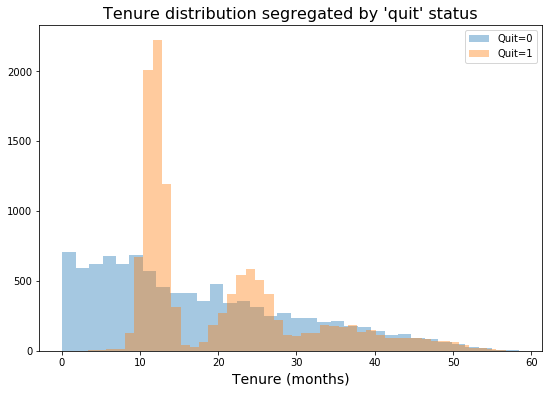

In [26]:
#some EDA
def distributionPlot(df,col,units,grouping='quit'):
    '''conveniently making EDA plots'''
    plt.figure(figsize=(9,6))
    sns.distplot(df.groupby(grouping)[col].get_group(0),kde=False,rug=False, label=grouping.capitalize()+'=0');
    sns.distplot(df.groupby(grouping)[col].get_group(1),kde=False,rug=False, label=grouping.capitalize()+'=1');
    plt.xlabel(col.capitalize()+units, fontsize=14)
    plt.title(col.capitalize()+' distribution segregated by \''+grouping+'\' status', fontsize=16);
    plt.legend();
    
distributionPlot(train,'tenure',' (months)')

/home/perro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/perro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


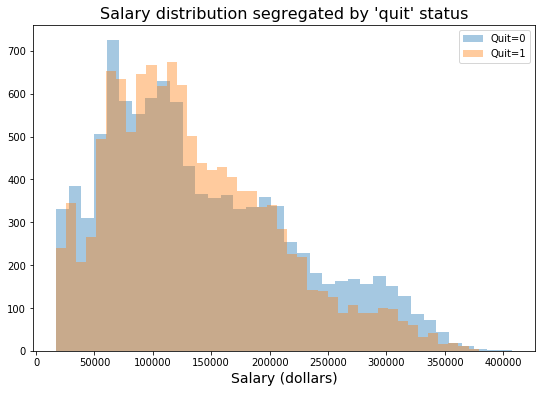

In [27]:
distributionPlot(train,'salary',' (dollars)')

/home/perro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/perro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


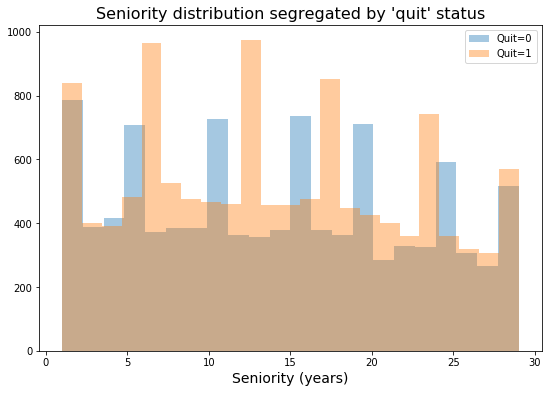

In [28]:
distributionPlot(train,'seniority',' (years)')

/home/perro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/perro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


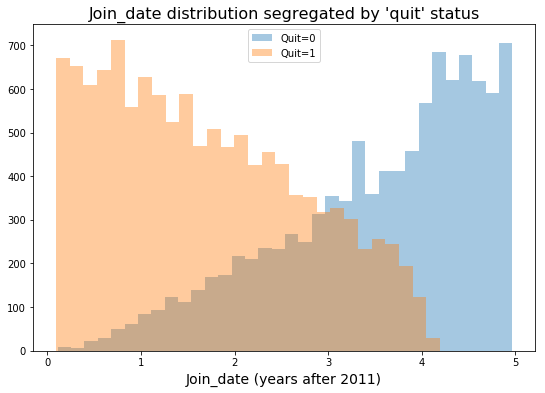

In [42]:
distributionPlot(train,'join_date',' (years after 2011)')
#this is a nice plot :)

* data distributions segregated by quitting status show that `salary` and `seniority` do not seem to play an obviously important role
* however it seems that **`join_date` is important** for predicting wheter an employee quits or not. Seems that the closest to the 'great recession' the employee joined the company, the longer the he or she stayed at the company. As the economy improved employees were more secure that they will be able to find jobs elsewhere
* department and company variables might show good predictive power
* I will use the original data to show these two variables (`dept` and `company_id`)

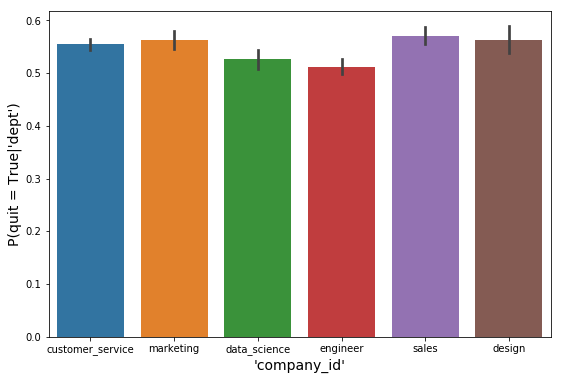

In [41]:
plt.figure(figsize=(9,6))
sns.barplot(x='dept',y='quit',data=data)
plt.xlabel('\'company_id\'', fontsize=14)
plt.ylabel('P(quit = True|\'dept\')', fontsize=14);
#there seems to be some statistically significant differences between departments (i.e engineer and sales or design)

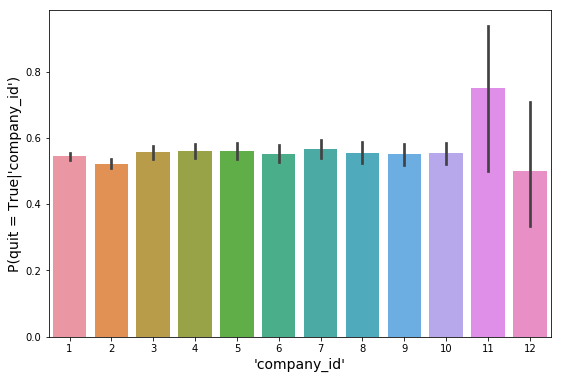

In [40]:
plt.figure(figsize=(9,6))
sns.barplot(x='company_id',y='quit',data=data)
plt.xlabel('\'company_id\'', fontsize=14)
plt.ylabel('P(quit = True|\'company_id\')', fontsize=14);
#the confidence bar sizes are obvious given the sizes of companies 11 and 12
#seems that company 2 has a bit of difference with respect to other companies

### Let's build a predictive model...
(logistic regression has already been loaded)

In [47]:
target='quit'
features = df.columns.tolist()
features

['seniority',
 'salary',
 'join_date',
 'quit_date',
 'quit',
 'tenure',
 'dept_customer_service',
 'dept_data_science',
 'dept_design',
 'dept_engineer',
 'dept_marketing',
 'dept_sales',
 'company_id_1',
 'company_id_2',
 'company_id_3',
 'company_id_4',
 'company_id_5',
 'company_id_6',
 'company_id_7',
 'company_id_8',
 'company_id_9',
 'company_id_10',
 'company_id_11',
 'company_id_12']

In [48]:
features.remove('quit') #the target
features.remove('quit_date')#will keep tenure which is obtained from join_date and quit_date
features

['seniority',
 'salary',
 'join_date',
 'tenure',
 'dept_customer_service',
 'dept_data_science',
 'dept_design',
 'dept_engineer',
 'dept_marketing',
 'dept_sales',
 'company_id_1',
 'company_id_2',
 'company_id_3',
 'company_id_4',
 'company_id_5',
 'company_id_6',
 'company_id_7',
 'company_id_8',
 'company_id_9',
 'company_id_10',
 'company_id_11',
 'company_id_12']

In [49]:
model1=LogisticRegression()

**scaling the data...**

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train[features])
X_test = scaler.transform(test[features])

In [51]:
model1.fit(X_train, train['quit'])
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(model1.score(X_train, train['quit'])))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(model1.score(X_test, test['quit'])))
#maybe overfitting?

Accuracy of Logistic regression classifier on training set: 0.95
Accuracy of Logistic regression classifier on test set: 0.94


* indeed **`join_date` is the most important feature**. Note that salary is the least important one!!

In [55]:
feat_importance = pd.DataFrame(data={'feature': features, 'coefficient': model1.coef_[0]})
feat_importance

,feature,coefficient
0,seniority,0.055041
1,salary,0.006682
2,join_date,-28.932032
3,tenure,-26.271436
4,dept_customer_service,3.481349
5,dept_data_science,3.420261
6,dept_design,3.475565
7,dept_engineer,3.307320
8,dept_marketing,3.535647
9,dept_sales,3.521635


### Predicting tenure:

In [62]:
reduced=df[df['quit']==1]
reduced.head()

,seniority,salary,join_date,quit_date,quit,tenure,dept_customer_service,dept_data_science,dept_design,dept_engineer,...,company_id_3,company_id_4,company_id_5,company_id_6,company_id_7,company_id_8,company_id_9,company_id_10,company_id_11,company_id_12
0,28,89000.0,3.254795,4.857534,1,19.220107,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,20,183000.0,2.353425,3.284932,1,11.170661,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,20,115000.0,1.394521,2.460274,1,12.780550,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,23,276000.0,0.819178,3.668493,1,34.169079,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,14,165000.0,1.106849,2.690411,1,18.990123,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [59]:
Rtrain,Rtest = model_selection.train_test_split(reduced,test_size=0.1,random_state=seed)

In [60]:
from sklearn.linear_model import LinearRegression
model2= LinearRegression()

In [72]:
Rtarget='quit_date'
Rfeatures = reduced.columns.tolist()
Rfeatures

['seniority',
 'salary',
 'join_date',
 'quit_date',
 'quit',
 'tenure',
 'dept_customer_service',
 'dept_data_science',
 'dept_design',
 'dept_engineer',
 'dept_marketing',
 'dept_sales',
 'company_id_1',
 'company_id_2',
 'company_id_3',
 'company_id_4',
 'company_id_5',
 'company_id_6',
 'company_id_7',
 'company_id_8',
 'company_id_9',
 'company_id_10',
 'company_id_11',
 'company_id_12']

In [73]:
Rfeatures.remove(Rtarget) #the target
Rfeatures.remove('quit')  
Rfeatures.remove('tenure') 
Rfeatures

['seniority',
 'salary',
 'join_date',
 'dept_customer_service',
 'dept_data_science',
 'dept_design',
 'dept_engineer',
 'dept_marketing',
 'dept_sales',
 'company_id_1',
 'company_id_2',
 'company_id_3',
 'company_id_4',
 'company_id_5',
 'company_id_6',
 'company_id_7',
 'company_id_8',
 'company_id_9',
 'company_id_10',
 'company_id_11',
 'company_id_12']

In [74]:
R_train = scaler.fit_transform(Rtrain[Rfeatures])
R_test = scaler.transform(Rtest[Rfeatures])

In [75]:
model2.fit(R_train, Rtrain[Rtarget])
print('R^2 of Linear regression on training set: {:.2f}'
     .format(model2.score(R_train, Rtrain[Rtarget])))
print('R^2 of Linear regression on test set: {:.2f}'
     .format(model2.score(R_test, Rtest[Rtarget])))
#very hard to estimate quit_date

R^2 of Linear regression on training set: 0.42
R^2 of Linear regression on test set: 0.40


In [78]:
Rfeat_importance = pd.DataFrame(data={'feature': Rfeatures, 'coefficient': model2.coef_})
Rfeat_importance

,feature,coefficient
0,seniority,-2.380067e-01
1,salary,5.859169e-01
2,join_date,2.647304e+00
3,dept_customer_service,8.413237e+12
4,dept_data_science,8.413237e+12
5,dept_design,8.413237e+12
6,dept_engineer,8.413237e+12
7,dept_marketing,8.413237e+12
8,dept_sales,8.413237e+12
9,company_id_1,-1.793222e+13
